# Exercise 2
## Two-Dimensional K-Nearest Neighbors Classifier Using Quad-Tree

We have implemented a two-dimensional k-nearest neighbors classifier. This implementation uses a quad-tree for efficient storage and retrieval of points. Below are the key components of this implementation:

### QuadTree Class
- Manages the overall structure and methods for the quad-tree.
- Contains a nested `Node` class representing each point in the tree along with its classification.

### Insertion Method
- Inserts new points with their classifications into the quad-tree.
- Organizes points based on their x and y coordinates, ensuring efficient spatial searching.

### K-Nearest Neighbors Method
- Finds the k nearest neighbors to a given point using Euclidean distance.
- Efficiently navigates the tree by only exploring relevant quadrants.

### Classification Method
- Classifies a new point by finding its k nearest neighbors and selecting the most common class among them.

In [3]:
class QuadTree:
    """
    QuadTree class for efficient k-nearest neighbors search.
    """

    class Node:
        """
        Node class representing each element in the QuadTree.
        """
        def __init__(self, point, classification):
            self.point = point  # The (x, y) coordinates
            self.classification = classification  # The class of the point
            self.children = [None, None, None, None]  # Children: NW, NE, SW, SE

    def __init__(self):
        self.root = None

    def insert(self, point, classification):
        """
        Insert a new point with its classification into the tree.
        """
        self.root = self._insert(self.root, point, classification, 0)

    def _insert(self, node, point, classification, depth):
        """
        Helper function to insert a new point in the tree.
        """
        if node is None:
            return self.Node(point, classification)

        # Determine the quadrant for the point
        x, y = point
        horizontal_mid = depth % 2 == 0
        if (horizontal_mid and x < node.point[0]) or (not horizontal_mid and y < node.point[1]):
            index = 0 if y < node.point[1] else 1  # NW or NE
        else:
            index = 2 if y < node.point[1] else 3  # SW or SE

        node.children[index] = self._insert(node.children[index], point, classification, depth + 1)
        return node

    def k_nearest_neighbors(self, point, k):
        """
        Find the k nearest neighbors to a given point.
        """
        neighbors = []
        self._k_nearest_neighbors(self.root, point, k, neighbors, 0)
        neighbors.sort(key=lambda x: x[0])
        return [n[1] for n in neighbors][:k]

    def _k_nearest_neighbors(self, node, point, k, neighbors, depth):
        """
        Helper function to find k nearest neighbors.
        """
        if node is None:
            return

        # Compute euclidean distance from point to current node
        distance = self._euclidean_distance(point, node.point)
        if len(neighbors) < k or distance < neighbors[-1][0]:
            neighbors.append((distance, node.classification))
            neighbors.sort(key=lambda x: x[0])
            if len(neighbors) > k:
                neighbors.pop()

        # Determine which side of the split line to explore first
        horizontal_mid = depth % 2 == 0
        index = 0 if (horizontal_mid and point[0] < node.point[0]) or (not horizontal_mid and point[1] < node.point[1]) else 1

        # Explore the preferred side of the split line first
        self._k_nearest_neighbors(node.children[index], point, k, neighbors, depth + 1)

        # Check if we need to explore the other side
        if (horizontal_mid and abs(point[0] - node.point[0]) < neighbors[-1][0]) or \
           (not horizontal_mid and abs(point[1] - node.point[1]) < neighbors[-1][0]):
            other_index = 1 - index
            self._k_nearest_neighbors(node.children[other_index], point, k, neighbors, depth + 1)

    @staticmethod
    def _euclidean_distance(point1, point2):
        """
        Compute the Euclidean distance between two points.
        """
        return ((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5

    def classify_point(self, point, k):
        """
        Classify a point based on the k nearest neighbors.
        """
        neighbors = self.k_nearest_neighbors(point, k)
        # Count the occurrences of each class in the neighbors
        classes = {}
        for neighbor in neighbors:
            classes[neighbor] = classes.get(neighbor, 0) + 1
        # Return the most common class
        return max(classes.items(), key=lambda x: x[1])[0]

### Example Usage
In this example, we insert several data points into the quad-tree and then classify a new point based on its 3 nearest neighbors.

In [4]:
# Example usage
qt = QuadTree()
data = [((2, 3), 'A'), ((5, 4), 'B'), ((9, 6), 'A'), ((4, 7), 'B'), ((8, 1), 'A'), ((7, 2), 'B')]
for point, classification in data:
    qt.insert(point, classification)

# Classify a new point
new_point = (5, 5)
k = 3
classification = qt.classify_point(new_point, k)
print(f"The point {new_point} is classified as '{classification}' based on its {k} nearest neighbors.")

The point (5, 5) is classified as 'A' based on its 3 nearest neighbors.


In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the data from the Excel file
file_path = 'Rice_Cammeo_Osmancik.xlsx'
data = pd.read_excel(file_path)

# Identifying the quantitative columns (assuming they are numerical and not categorical)
quantitative_columns = data.select_dtypes(include=['float', 'int']).columns

# Normalize the quantitative columns to have a mean of 0 and a standard deviation of 1
scaler = StandardScaler()
data[quantitative_columns] = scaler.fit_transform(data[quantitative_columns])

# Displaying the first few rows of the normalized data
data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,1.479830,2.004354,2.348547,-0.212943,2.018337,1.499659,-1.152921,Cammeo
1,1.147870,1.125853,0.988390,0.945568,0.410018,1.192918,-0.602079,Cammeo
2,1.135169,1.317214,1.451908,0.253887,1.212956,1.126504,0.405611,Cammeo
3,0.293436,0.115300,0.261439,0.198051,0.239751,0.233857,-0.275351,Cammeo
4,1.166345,1.487053,1.316442,0.523419,0.952221,1.299855,-0.206013,Cammeo


## K-Nearest Neighbors Effectiveness on PCA-Reduced Rice Data

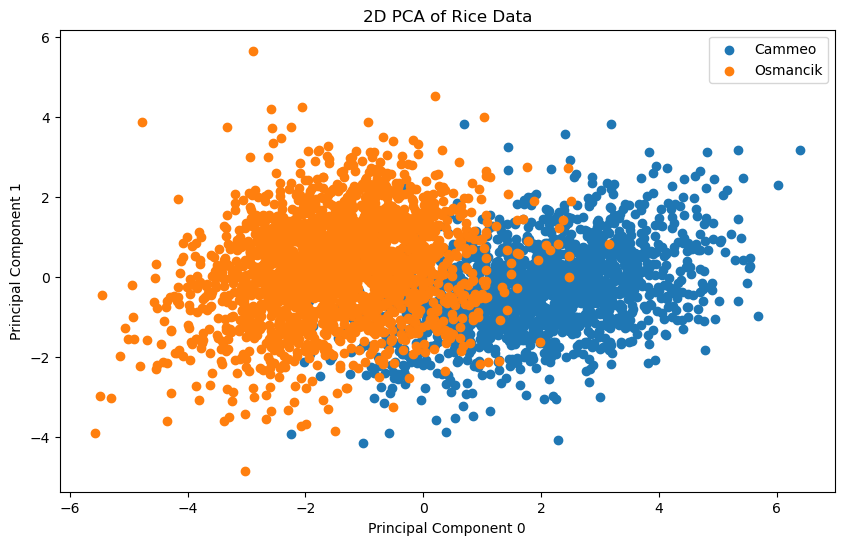

In [6]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Applying PCA to reduce the data to two dimensions
pca = PCA(n_components=2)
data_reduced = pca.fit_transform(data[quantitative_columns])

# Extracting the first and second principal components
pc0 = data_reduced[:, 0]
pc1 = data_reduced[:, 1]

# Creating a scatter plot, color-coded by the type of rice
plt.figure(figsize=(10, 6))
for class_value in data['Class'].unique():
    # Select data corresponding to each class
    idx = data['Class'] == class_value
    plt.scatter(pc0[idx], pc1[idx], label=class_value)

plt.xlabel('Principal Component 0')
plt.ylabel('Principal Component 1')
plt.title('2D PCA of Rice Data')
plt.legend()
plt.show()

### Observations:
- **Cluster Separation**: The two types of rice, Cammeo and Osmancik, form distinct clusters. This separation is indicative of a high potential for KNN to accurately classify the majority of the data points.

- **Overlap Area**: The presence of an overlap between the clusters suggests that the performance of KNN might be compromised in this region. The selection of an appropriate 'k' value will be important to balance the influence of the nearest neighbors from both classes.

- **Density of Points**: The central areas of the clusters are densely populated, suggesting that KNN would be highly effective in these regions due to the higher likelihood of a point's nearest neighbors belonging to the same class.

- **Outliers**: The lack of significant outliers suggests that KNN will not be unduly influenced by anomalous data points, leading to more stable classification predictions.

### Conclusion:
The PCA reduction has resulted in a two-dimensional space where the two classes of rice are mostly separable, indicating that KNN could be an effective classification method for this dataset. However, careful consideration of the 'k' value and possible weight adjustments based on distance may be required to optimize performance, especially in the overlap area between the clusters.

## K-Nearest Neighbors Classification and Confusion Matrix Analysis

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

# Split the data into features and target variable
X = data[quantitative_columns]
y = data['Class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize the training data and transform the test data using the same scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Fit PCA on the training data and transform both the training and test data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Function to perform KNN classification and return the confusion matrix
def knn_confusion_matrix(k, X_train, y_train, X_test, y_test):
    # Initialize the KNN classifier with the specified k
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the classifier on the training data
    knn.fit(X_train, y_train)
    
    # Predict the classes for the test data
    y_pred = knn.predict(X_test)
    
    # Generate and return the confusion matrix
    return confusion_matrix(y_test, y_pred)

# Confusion matrix for k=1
conf_matrix_k1 = knn_confusion_matrix(1, X_train_pca, y_train, X_test_pca, y_test)

# Confusion matrix for k=5
conf_matrix_k5 = knn_confusion_matrix(5, X_train_pca, y_train, X_test_pca, y_test)

conf_matrix_k1, conf_matrix_k5

(array([[447,  71],
        [ 52, 573]], dtype=int64),
 array([[466,  52],
        [ 47, 578]], dtype=int64))

**Interpretation of Results**:
   - The confusion matrix provides a breakdown of correct and incorrect predictions.
   - Diagonal elements correspond to correct predictions (true positives and true negatives).
   - Off-diagonal elements indicate misclassifications (false positives and false negatives).
   - A confusion matrix for `k=1` may show more sensitivity to noise (overfitting).
   - A confusion matrix for `k=5` may indicate a more generalized model that could be more robust but less sensitive to data specifics.